In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import random
from collections import namedtuple, deque
import numpy as np
import math

In [2]:
# --- Define Replay Buffer ---
Experience = namedtuple('Experience',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# --- Define DQN Network ---
class DQNNet(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQNNet, self).__init__()

        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- Main Training Loop ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
TARGET_UPDATE_FREQ = 10 
REPLAY_BUFFER_CAPACITY = 10000

env = gym.make('CartPole-v1')
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

main_net = DQNNet(n_observations, n_actions).to(device)
target_net = DQNNet(n_observations, n_actions).to(device)

target_net.load_state_dict(main_net.state_dict())

optimizer = optim.AdamW(main_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayBuffer(REPLAY_BUFFER_CAPACITY)
steps_done = 0

def select_action(state):
    # Choose action using epsilon-greedy strategy
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return main_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_model():
        if len(memory) < BATCH_SIZE:
            return
        # 1. Uniformly draw a mini-batch of samples from B
        experiences = memory.sample(BATCH_SIZE)
        batch = Experience(*zip(*experiences))

        state_batch = torch.cat(batch.state).to(device)
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).to(device)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])


        # 2. Compute Q(s_t, a_t) - the model computes Q(s_t), then we select the columns of actions taken
        current_q_values = main_net(state_batch).gather(1, action_batch)

        # 3. Compute target value y_T
        next_state_q_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_q_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q value
        target_q_values = (next_state_q_values * GAMMA) + reward_batch

        # 4. Update the model (use Smooth L1 Loss (Huber Loss) here)
        criterion = nn.SmoothL1Loss()
        loss = criterion(current_q_values, target_q_values.unsqueeze(1))

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(main_net.parameters(), 100)
        optimizer.step()

        return loss.item()

Episode 1 | Duration: 33
Episode 2 | Duration: 13
Episode 3 | Duration: 32
Episode 4 | Duration: 15
Episode 5 | Duration: 11
Episode 6 | Duration: 13
Episode 7 | Duration: 25
Episode 8 | Duration: 25
Episode 9 | Duration: 23
Episode 10 | Duration: 16
Episode 11 | Duration: 16
Episode 12 | Duration: 15
Episode 13 | Duration: 16
Episode 14 | Duration: 17
Episode 15 | Duration: 10
Episode 16 | Duration: 19
Episode 17 | Duration: 11
Episode 18 | Duration: 13
Episode 19 | Duration: 12
Episode 20 | Duration: 14
Episode 21 | Duration: 12
Episode 22 | Duration: 11
Episode 23 | Duration: 10
Episode 24 | Duration: 13
Episode 25 | Duration: 12
Episode 26 | Duration: 11
Episode 27 | Duration: 12
Episode 28 | Duration: 18
Episode 29 | Duration: 18
Episode 30 | Duration: 11
Episode 31 | Duration: 13
Episode 32 | Duration: 10
Episode 33 | Duration: 12
Episode 34 | Duration: 22
Episode 35 | Duration: 8
Episode 36 | Duration: 12
Episode 37 | Duration: 14
Episode 38 | Duration: 10
Episode 39 | Duration:

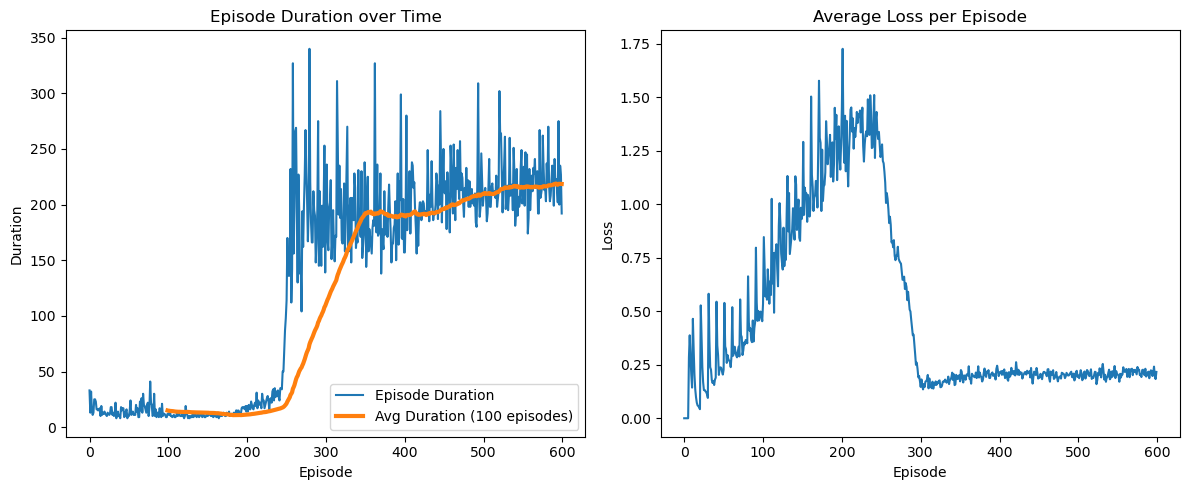

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- Train Loop ---
if __name__ == '__main__':
    num_episodes = 600


    episode_durations = []
    episode_losses = []
    avg_durations_100 = []

    for i_episode in range(num_episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        done = False

        total_loss = 0
        steps_in_episode = 0

        while not done:
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            reward = torch.tensor([reward], device=device)

            if done:
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            memory.push(state, action, reward, next_state, done)
            state = next_state

            # Train the model and accumulate loss
            loss = optimize_model()
            if loss is not None:
                total_loss += loss

            steps_in_episode += 1

        # Record episode duration and average loss
        episode_durations.append(steps_in_episode)
        if steps_in_episode > 0:
            episode_losses.append(total_loss / steps_in_episode) # Average loss per step in the episode
        else:
            episode_losses.append(0)

        # Calculate and print average duration every 100 episodes
        if i_episode >= 99:
            avg_duration = np.mean(episode_durations[-100:])
            avg_durations_100.append(avg_duration)
            print(f"Episode {i_episode+1} | Avg Duration (Last 100): {avg_duration:.2f} | Avg Loss: {episode_losses[-1]:.4f}")
        else:
            print(f"Episode {i_episode+1} | Duration: {steps_in_episode}")

        # Update target network every TARGET_UPDATE_FREQ episodes
        if i_episode % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(main_net.state_dict())

    print('--- Training Finished ---')

    # Figure 1: Episode Duration and Average Duration
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_durations, label='Episode Duration')

    avg_plot_data = [None] * 99 + avg_durations_100
    plt.plot(avg_plot_data, label='Avg Duration (100 episodes)', linewidth=3)
    plt.title('Episode Duration over Time')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.legend()

    # Figure 2: Average Loss per Episode
    plt.subplot(1, 2, 2)
    plt.plot(episode_losses)
    plt.title('Average Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()